# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# В проекте будем решать задачу регрессии. Загрузим библиотеки, которые будут использоваться
import pandas as pd
import numpy as np
from statistics import mode

import matplotlib.pyplot as plt

# Модели на основе градиентного бустинга
from catboost import (
    CatBoostRegressor,
    cv as cb_cv,
    Pool)

from lightgbm import (
    LGBMRegressor,
    cv as lgbm_cv,
    plot_importance)

# Не будем ограничиваться градиентным бустингом. Попробуем более простые модели: линейной регрессии и случайного леса
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate
)
from sklearn.metrics import mean_squared_error

# Для масштабирования и кодирования признаков
from category_encoders import *
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

# Константы
RANDOM_STATE = 12345

## Загрузка и ознакомление с данными

In [2]:
# Загрузим данные из файлов
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
# Рассмотрим первые строки и общие сведения
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Каждый объект в наборе данных — это информация об автомобиле. Столбцы содержат следующую информацию (признаки):
- `DateCrawled` — дата скачивания анкеты из базы,
- `VehicleType` — тип автомобильного кузова,
- `RegistrationYear` — год регистрации автомобиля,
- `Gearbox` — тип коробки передач,
- `Power` — мощность (л. с.),
- `Model` — модель автомобиля,
- `Kilometer` — пробег (км),
- `RegistrationMonth` — месяц регистрации автомобиля,
- `FuelType` — тип топлива,
- `Brand` — марка автомобиля,
- `Repaired` — была машина в ремонте или нет,
- `DateCreated` — дата создания анкеты,
- `NumberOfPictures` — количество фотографий автомобиля,
- `PostalCode` — почтовый индекс владельца анкеты (пользователя),
- `LastSeen` — дата последней активности пользователя,
- `Price` - цена (евро). **Целевой признак.**

## Подготовка данных

### Дубликаты

In [5]:
# Проверим полные дубликаты
df.duplicated().sum()

4

In [6]:
# Посмотрим на объекты-дубликаты
df[df.duplicated(keep=False)].sort_values(by=['DateCrawled', 'VehicleType', 'RegistrationYear', 'Gearbox'])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [7]:
# Удалим дубликаты
df = df.drop_duplicates(keep='first')

In [8]:
# Проработаем неявные дубликаты признака `VehicleType`
df['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Неявных дубликатов нет

In [9]:
# Проработаем неявные дубликаты признака `Gearbox`
df['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

Неявных дубликатов нет

In [10]:
# Проработаем неявные дубликаты признака `Model`
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Заменим неявные дубликаты

In [11]:
df['Model'] = df['Model'].replace(to_replace='rangerover', value='range_rover', regex=False)

In [12]:
# Проработаем неявные дубликаты признака `FuelType`
df['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Неявных дубликатов нет

In [13]:
# Проработаем неявные дубликаты признака `Brand`
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Неявных дубликатов нет

In [14]:
# Проработаем неявные дубликаты признака `Repaired`
df['Repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Неявных дубликатов нет

### Типы

Преобразуем тип данных в столбцах `DateCrawled`, `DateCreated`, `LastSeen` в тип дата-время. С точки зрения исследования нам необходимо знать только дату, поэтому отбросим часы, минуты, секунды. Перед тем, как передать методу преобразования типов, удалим пробелы в начале и в конце значения.

In [15]:
for feature in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[feature] = df[feature].str.strip()
    df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d %H:%M:%S')
    df[feature] = pd.to_datetime(df[feature].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

### Пропуски и аномалии в категориальных признаках

In [16]:
# Посчитаем пропуски.
display(df.isna().sum().sort_values(ascending=False))
df.isna().mean().sort_values(ascending=False)

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Repaired             0.200793
VehicleType          0.105795
FuelType             0.092828
Gearbox              0.055968
Model                0.055607
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Видим пропуски в колонках: `Repaired`, `VehicleType`, `FuelType`, `Gearbox`, `Model`. Заполнение пропусков будем выполнять следующим образом:
- в колонке `Repaired` пропуски заполним значением 'no info', так как информация для обоснованного заполнения пропусков у нас отсутствует,
-  в колонках `VehicleType`, `FuelType`, `Model` пропуски заполним значением 'other', так как информация для обоснованного заполнения пропусков у нас отсутствует, и в указанных колонках уже присутствуют значения 'other',
- в колонке `Gearbox` заполним пропуски модой по бренду (наиболее распространённое значение по определённому бренду).

In [17]:
# Заполним пропуски 'Repaired' заглушкой 'no info'
df['Repaired'] = df['Repaired'].fillna('no info')

# Заполним пропуски 'VehicleType', 'FuelType', `Model` заглушкой 'other'
df['VehicleType'] = df['VehicleType'].fillna('other')
df['FuelType'] = df['FuelType'].fillna('other')
df['Model'] = df['Model'].fillna('other')

In [18]:
# Для того, чтоб в дальнейшем не было утечки данных при заполнении пропусков, разделим выборки на обучающую и тестовую
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_index = train.index
test_index = test.index
print('Обучающая выборка: ', train.shape[0], ', ',  round(train.shape[0]/df.shape[0], 2), sep='')
print('Тестовая выборка: ', test.shape[0], ', ', round(test.shape[0]/df.shape[0], 2), sep='')

Обучающая выборка: 283492, 0.8
Тестовая выборка: 70873, 0.2


In [19]:
# Заполним пропуски 'Gearbox' модой по брендам
# Моду будем определять среди объектов только обучающей выборки
df['filled_by_train'] = df[df.index.isin(train_index)]['Gearbox']
df['filled_by_train'] = df['filled_by_train'].fillna(df.groupby(['Brand'], group_keys=True, dropna=True)['filled_by_train']. \
                                                     transform(lambda x: x if x.mode().empty else x.mode().values[0]))
df['Gearbox'] = df['filled_by_train']
df = df.drop(['filled_by_train'], axis=1)

In [20]:
# Посчитаем пропуски после их заполнения.
display(df.isna().sum().sort_values(ascending=False))

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Пропуски заполнены. Кроме того, по категориальным признакам не было зафиксировано аномальных значений.

### Аномалии в числовых признаках

In [21]:
# Изучим столбец RegistrationYear
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Очевидно, в данных о годе регистрации какая-то ошибка, например, имеются значения 1000 и 9000. Рассмотрим данные подробнее.

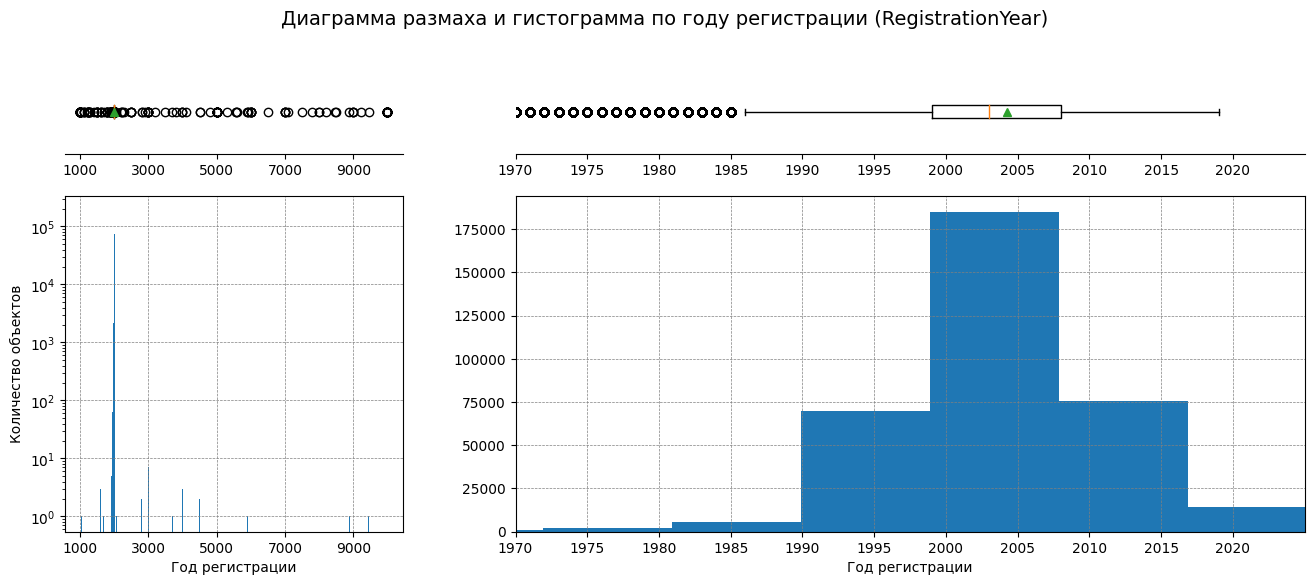

In [22]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку год в большинстве случаев не превышает 2020 и не ниже 1980, а минимальное и максимальное значение
# составляют 1000 и 9999, то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон, а справа - с ограничением от 1970 до 2025.
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=2, nrows=2,
                       figsize=(16, 6),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.2, .8), 'width_ratios': (.3, .7)})
fig.suptitle('Диаграмма размаха и гистограмма по году регистрации (RegistrationYear)', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1, 0].set_xticks(np.arange(1000, 10000, 2000))
ax[1, 1].set_xticks(np.arange(1970, 2025, 5))
ax[1, 0].set_yscale('log')
#ax[1, 1].set_yscale('log')
ax[1, 1].set_xlim(1970,2025)
ax[1,0].set_xlabel('Год регистрации')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Год регистрации')
# Построим сами диаграммы
ax[0,0].boxplot(df[~(df['RegistrationYear'].isna())]['RegistrationYear'], vert=False, showmeans=True)
ax[0,1].boxplot(df[~(df['RegistrationYear'].isna())]['RegistrationYear'], vert=False, showmeans=True)
ax[1,0].hist(df['RegistrationYear'], bins=1000)
ax[1,1].hist(df['RegistrationYear'], bins=1000)
plt.show()

Видно, что практически все значения находятся в диапазоне 1985-2023. Рассмотрим, какие объекты имеют аномальные значения года регистрации.

In [23]:
print('Аномальных объектов', df[(df['RegistrationYear']<1985)|(df['RegistrationYear']>2023)]['RegistrationYear'].count())

Аномальных объектов 5553


In [24]:
df[(df['RegistrationYear']<1985)|(df['RegistrationYear']>2023)].sample(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
98700,2016-03-22,550,sedan,1974,manual,0,kadett,100000,8,other,opel,no info,2016-03-22,0,92693,2016-03-22
119458,2016-03-15,1500,sedan,1975,manual,76,other,70000,1,petrol,lada,no info,2016-03-15,0,99091,2016-03-21
105383,2016-03-10,7000,other,1980,manual,110,other,150000,4,other,bmw,no info,2016-03-10,0,64546,2016-03-10
50440,2016-04-03,0,sedan,1984,auto,135,other,150000,0,petrol,mercedes_benz,no info,2016-04-03,0,36037,2016-04-05
246499,2016-03-08,550,small,1983,manual,34,kaefer,150000,6,petrol,volkswagen,yes,2016-03-08,0,98716,2016-03-18
324519,2016-03-29,1,other,1970,manual,0,kaefer,5000,0,other,volkswagen,no,2016-03-29,0,88353,2016-04-01
202983,2016-03-08,5500,coupe,1979,auto,185,sl,5000,8,petrol,mercedes_benz,no,2016-03-08,0,58644,2016-04-06
106707,2016-03-15,9900,convertible,1979,manual,120,other,150000,7,petrol,lancia,no,2016-03-14,0,81739,2016-04-05
70172,2016-03-31,13950,convertible,1962,manual,80,other,100000,7,petrol,sonstige_autos,no info,2016-03-31,0,45665,2016-04-06
81329,2016-03-27,5000,coupe,1984,manual,179,other,150000,9,petrol,opel,no,2016-03-27,0,12305,2016-04-07


Какой-либо закономерности, которая позволила бы понять причины возникновения таких аномальных значений, не наблюдается. Заменим такие аномальные значения медианным значением по автомобилям с аналогичным пробегом после изучения и корректировки значений в столбце с пробегом.

In [25]:
# Изучим столбец Kilometer
df['Kilometer'].describe()

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

По данным о пробеге можно сказать, что абсолютное большинство автомобилей с пробегом 100 тыс км и более. Рассмотрим данные подробнее.

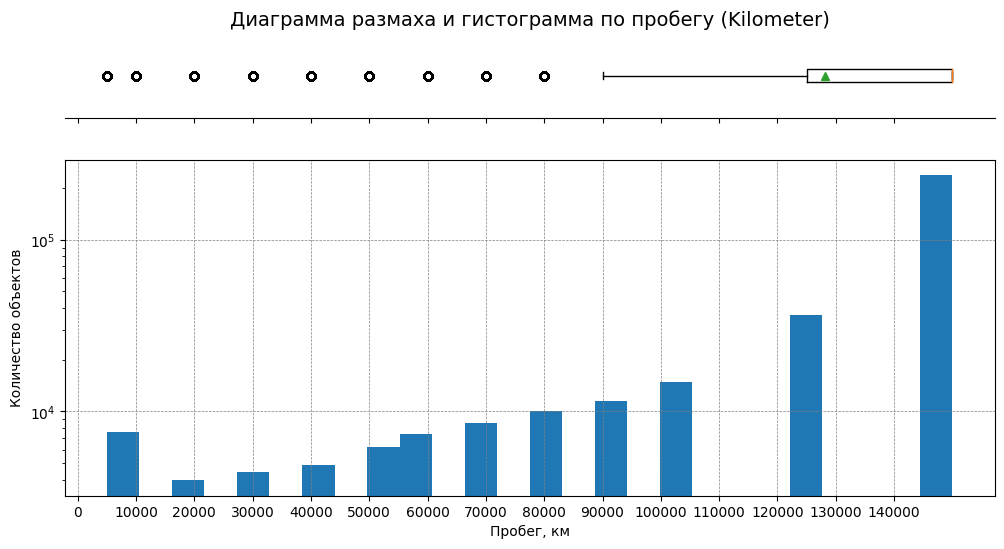

In [26]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(12, 6),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.2, .8)})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1].set_xticks(np.arange(0, 150000, 10000))
ax[0].set_title('Диаграмма размаха и гистограмма по пробегу (Kilometer)', fontsize=14)
ax[1].set_xlabel('Пробег, км')
ax[1].set_ylabel('Количество объектов')
ax[1].set_yscale('log')
# Построим сами диаграммы
ax[0].boxplot(df[~(df['Kilometer'].isna())]['Kilometer'], vert=False, showmeans=True)
ax[1].hist(df['Kilometer'], bins=26)
plt.show()

In [27]:
df['Kilometer'].value_counts()

Kilometer
150000    238207
125000     36453
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3974
10000       1222
Name: count, dtype: int64

Видим, что значение пробега представлено круглыми значениями с различным шагом. Аномальных значений не наблюдается.

In [28]:
# Заменим аномальные значения года регистрации медианным значением по автомобилям с аналогичным пробегом
# Медиану будем определять среди объектов только обучающей выборки и с годом регистрации в диапазоне 1985-2023
df['filled_by_train'] = df[df.index.isin(train_index)&((df['RegistrationYear']>1985)&(df['RegistrationYear']<2023))]['RegistrationYear']
df['filled_by_train'] = df['filled_by_train'].fillna(df.groupby(['Kilometer'], group_keys=True, dropna=True)['filled_by_train'].transform('median'))
# Заменим аномальные значения в исходном столбце
df.loc[(df['RegistrationYear']<1985)|(df['RegistrationYear']>2023), 'RegistrationYear'] = \
df.loc[(df['RegistrationYear']<1985)|(df['RegistrationYear']>2023),'filled_by_train']
# Удалим временный столбец
df = df.drop(['filled_by_train'], axis=1)

In [29]:
#Проверим, что получилось
df['RegistrationYear'].describe()

count    354365.000000
mean       2003.572509
std           6.396470
min        1985.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

Аномалии из столбца с годом регистрации убрали

In [30]:
# Изучим столбец RegistrationMonth
df['RegistrationMonth'].value_counts()

RegistrationMonth
0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: count, dtype: int64

Видим, что имеется аномальное значение месяца - 0. Такие значения заполним медианным значением месяца среди объектов с тем же годом регистрации и с аналогичным пробегом, у которых значение месяца не равно нулю.

In [31]:
# Заменим аномальные значения месяца регистрации медианным значением по автомобилям с аналогичным пробегом и годом регистрации
# Медиану будем определять среди объектов только обучающей выборки, у которых месяц регистрации имеет значение в диапазоне от 1 до 12
df['filled_by_train'] = df[df.index.isin(train_index)&(df['RegistrationMonth']!=0)]['RegistrationMonth']
df['filled_by_train'] = df['filled_by_train'].fillna(df.groupby(['RegistrationYear', 'Kilometer'], group_keys=True, dropna=True)['filled_by_train'].transform('median'))
# Оставшиеся незаполненными значения заполним модой по столбцу с месяцем
df['filled_by_train'] = df['filled_by_train'].fillna(df['filled_by_train'].mode().values[0])
# Заменим аномальные значения в исходном столбце
df.loc[df['RegistrationMonth']==0, 'RegistrationMonth'] = df.loc[df['RegistrationMonth']==0, 'filled_by_train']
df['RegistrationMonth'] = df['RegistrationMonth'].astype('int')
# Удалим временный столбец
df = df.drop(['filled_by_train'], axis=1)

In [32]:
# Проверим, что получилось
df['RegistrationMonth'].value_counts()

RegistrationMonth
6     62824
3     34546
5     30987
7     30601
4     29398
10    26103
12    24289
11    24186
9     23884
1     23233
8     23041
2     21273
Name: count, dtype: int64

Аномалии из столбца с месяцем регистрации убрали

In [33]:
# Изучим столбец Power
df['Power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Видим, что среди значений мощности имеются аномальные значения, изучим данные подробнее.

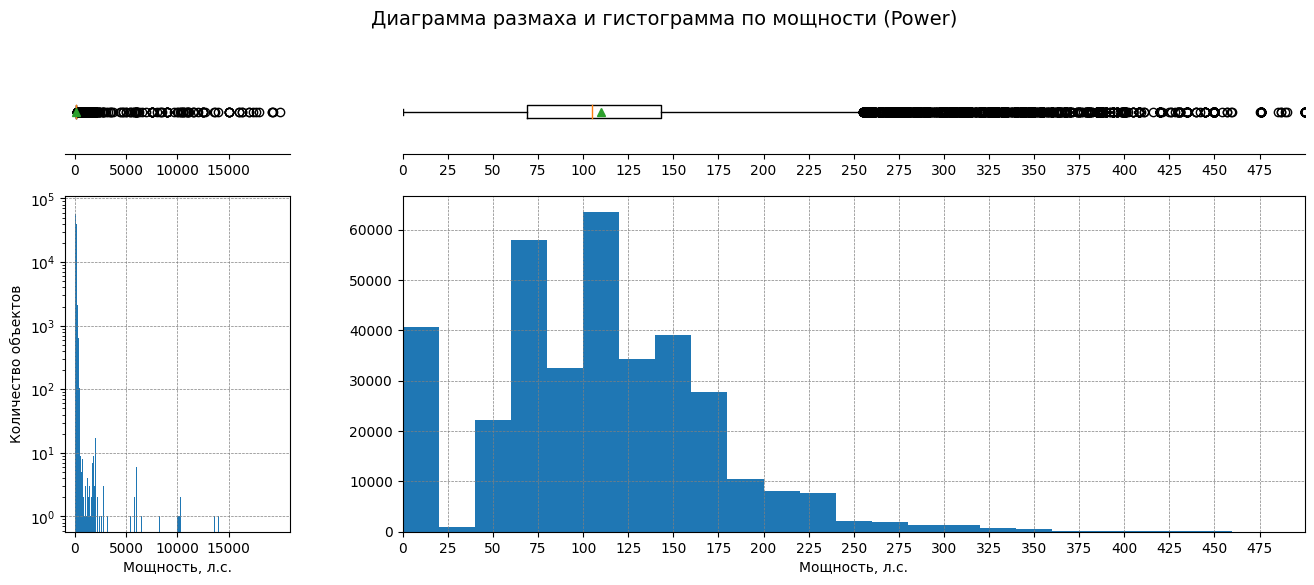

In [34]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Поскольку мощность в большинстве случаев не превышает 350 л.с. и не ниже 50 л.с., а минимальное и максимальное значение
# составляют 0 и 20000, то построим диаграммы в разных масштабах:
# слева будут диаграммы на весь диапазон, а справа - с ограничением от 50 до 500.
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=2, nrows=2,
                       figsize=(16, 6),
                       sharex=False,
                       gridspec_kw={'height_ratios': (.2, .8), 'width_ratios': (.2, .8)})
fig.suptitle('Диаграмма размаха и гистограмма по мощности (Power)', fontsize=14)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)
ax[0, 0].tick_params(axis='y', left=False, labelleft=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].tick_params(axis='y', left=False, labelleft=False)
ax[1, 0].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1, 1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[0,0].sharex(ax[1, 0])
ax[0,1].sharex(ax[1, 1])
ax[1, 0].set_xticks(np.arange(0, 20000, 5000))
ax[1, 1].set_xticks(np.arange(0, 500, 25))
ax[1, 0].set_yscale('log')
#ax[1, 1].set_yscale('log')
ax[1, 1].set_xlim(0,500)
ax[1,0].set_xlabel('Мощность, л.с.')
ax[1,0].set_ylabel('Количество объектов')
ax[1,1].set_xlabel('Мощность, л.с.')
# Построим сами диаграммы
ax[0,0].boxplot(df[~(df['Power'].isna())]['Power'], vert=False, showmeans=True)
ax[0,1].boxplot(df[~(df['Power'].isna())]['Power'], vert=False, showmeans=True)
ax[1,0].hist(df['Power'], bins=1000)
ax[1,1].hist(df['Power'], bins=1000)
plt.show()

In [35]:
print('Количество аномальных объектов по мощности (общее)', df[(df['Power']<40)|(df['Power']>450)]['Power'].count())
print('Количество аномальных объектов по мощности (<40 л.с.)', df[(df['Power']==0)]['Power'].count())
print('Количество аномальных объектов по мощности (>450 л.с.)', df[(df['Power']>450)]['Power'].count())

Количество аномальных объектов по мощности (общее) 42195
Количество аномальных объектов по мощности (<40 л.с.) 40225
Количество аномальных объектов по мощности (>450 л.с.) 540


In [36]:
df[(df['Power']>450)].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22600,2016-04-04,15000,sedan,2002,manual,500,golf,150000,11,petrol,volkswagen,no,2016-04-04,0,38442,2016-04-07
187283,2016-03-17,300,bus,1992,manual,1230,transporter,150000,3,gasoline,volkswagen,yes,2016-03-17,0,45770,2016-03-25
119692,2016-03-20,3000,small,2013,manual,1000,other,150000,5,petrol,ford,yes,2016-03-20,0,4626,2016-04-06
155997,2016-04-04,16500,wagon,2003,manual,510,other,125000,3,petrol,audi,no,2016-04-04,0,96476,2016-04-06
19947,2016-03-16,14888,sedan,2003,auto,476,e_klasse,150000,7,petrol,mercedes_benz,no,2016-03-16,0,31134,2016-04-05
104463,2016-03-28,11399,other,1995,manual,1995,other,150000,12,gasoline,bmw,no info,2016-03-28,0,90459,2016-04-07
92455,2016-03-15,6900,sedan,2007,manual,1968,passat,150000,5,gasoline,volkswagen,no,2016-03-15,0,20257,2016-03-20
96608,2016-03-11,1700,other,2017,manual,9010,other,100000,5,petrol,volkswagen,no,2016-03-11,0,99706,2016-03-20
107266,2016-03-23,120,other,2010,auto,500,sl,10000,5,other,mercedes_benz,no info,2016-03-23,0,48268,2016-03-28
35168,2016-03-16,2599,other,2016,manual,1779,zafira,150000,6,petrol,opel,no,2016-03-14,0,60326,2016-04-06


In [37]:
df[(df['Power']<40)].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
72071,2016-03-11,1500,convertible,2001,manual,0,mx_reihe,150000,8,petrol,mazda,no info,2016-03-11,0,45886,2016-03-11
250106,2016-03-18,1900,other,2005,manual,0,zafira,150000,5,gasoline,opel,no,2016-03-18,0,82431,2016-04-05
7760,2016-03-28,4400,suv,2001,manual,0,jimny,125000,8,petrol,suzuki,no info,2016-03-28,0,86922,2016-04-07
210744,2016-03-25,2900,other,2009,manual,0,matiz,40000,9,other,chevrolet,no info,2016-03-25,0,45327,2016-04-06
57145,2016-04-01,150,other,2000,manual,0,punto,150000,10,petrol,fiat,no info,2016-04-01,0,94163,2016-04-05
19208,2016-03-27,1399,small,2004,manual,0,punto,125000,5,petrol,fiat,no,2016-03-27,0,13357,2016-04-01
283264,2016-03-28,1750,other,2017,manual,0,espace,150000,1,other,renault,no info,2016-03-28,0,26169,2016-04-01
245776,2016-03-17,0,sedan,2002,auto,0,other,150000,3,petrol,sonstige_autos,no info,2016-03-17,0,88484,2016-03-23
126741,2016-03-19,2700,bus,2005,manual,0,berlingo,150000,1,gasoline,citroen,no,2016-03-19,0,56567,2016-04-06
264925,2016-03-22,6155,bus,2006,manual,0,touran,150000,10,gasoline,volkswagen,no,2016-03-22,0,94094,2016-03-22


По некоторым объектам можно предположить, что аномально большое значение мощности появилось потому, что ошибочно вместо мощности в колонку вписан объём двигателя. По остальным объектам объяснить причину таких больших значений мощности, как, например, 15033, затруднительно. Также по имеющимся данным затруднительно предположить причины, по которым в столбце мощность имеются значения меньше 40 л.с. Заменим все значения мощности менее 40 л.с., а также значения более 450 л.с. медианным значением мощности для таких же марки и модели. Медиану будем определять по обучающей выборке.

In [38]:
# Заменим аномальные значения мощности медианным значением по автомобилям таких же марки и модели
# Медиану будем определять среди объектов только обучающей выборки, у которых мощность больше 0 и менее 450.
df['filled_by_train'] = df[df.index.isin(train_index)&((df['Power']>=40)&(df['Power']<=450))]['Power']
df['filled_by_train'] = df['filled_by_train'].fillna(df.groupby(['Brand', 'Model'], group_keys=True, dropna=True)['filled_by_train'].transform('median'))
# Оставшиеся незаполненными значения заполним медианой по автомобилям такой же марки
df['filled_by_train'] = round(df['filled_by_train'].fillna(df.groupby(['Brand'], group_keys=True, dropna=True)['filled_by_train'].transform('median')))

# Заменим аномальные значения в исходном столбце
df.loc[(df['Power']<40)|(df['Power']>450), 'Power'] = df.loc[(df['Power']<40)|(df['Power']>450), 'filled_by_train']
df['Power'] = df['Power'].astype('int')
# Удалим временный столбец
df = df.drop(['filled_by_train'], axis=1)

In [39]:
# Проверим, что получилось
df['Power'].describe()

count    354365.000000
mean        118.996320
std          51.688714
min          40.000000
25%          75.000000
50%         110.000000
75%         147.000000
max         450.000000
Name: Power, dtype: float64

Аномалии из столбца с мощностью убрали

In [40]:
# Изучим столбцы DateCrawled, DateCreated, LastSeen
df[['DateCreated', 'DateCrawled', 'LastSeen']].describe()

,DateCreated,DateCrawled,LastSeen
count,354365,354365,354365
mean,2016-03-20 19:12:06.583042560,2016-03-20 21:16:57.354422784,2016-03-29 11:28:30.788594176
min,2014-03-10 00:00:00,2016-03-05 00:00:00,2016-03-05 00:00:00
25%,2016-03-13 00:00:00,2016-03-13 00:00:00,2016-03-23 00:00:00
50%,2016-03-21 00:00:00,2016-03-21 00:00:00,2016-04-03 00:00:00
75%,2016-03-29 00:00:00,2016-03-29 00:00:00,2016-04-06 00:00:00
max,2016-04-07 00:00:00,2016-04-07 00:00:00,2016-04-07 00:00:00


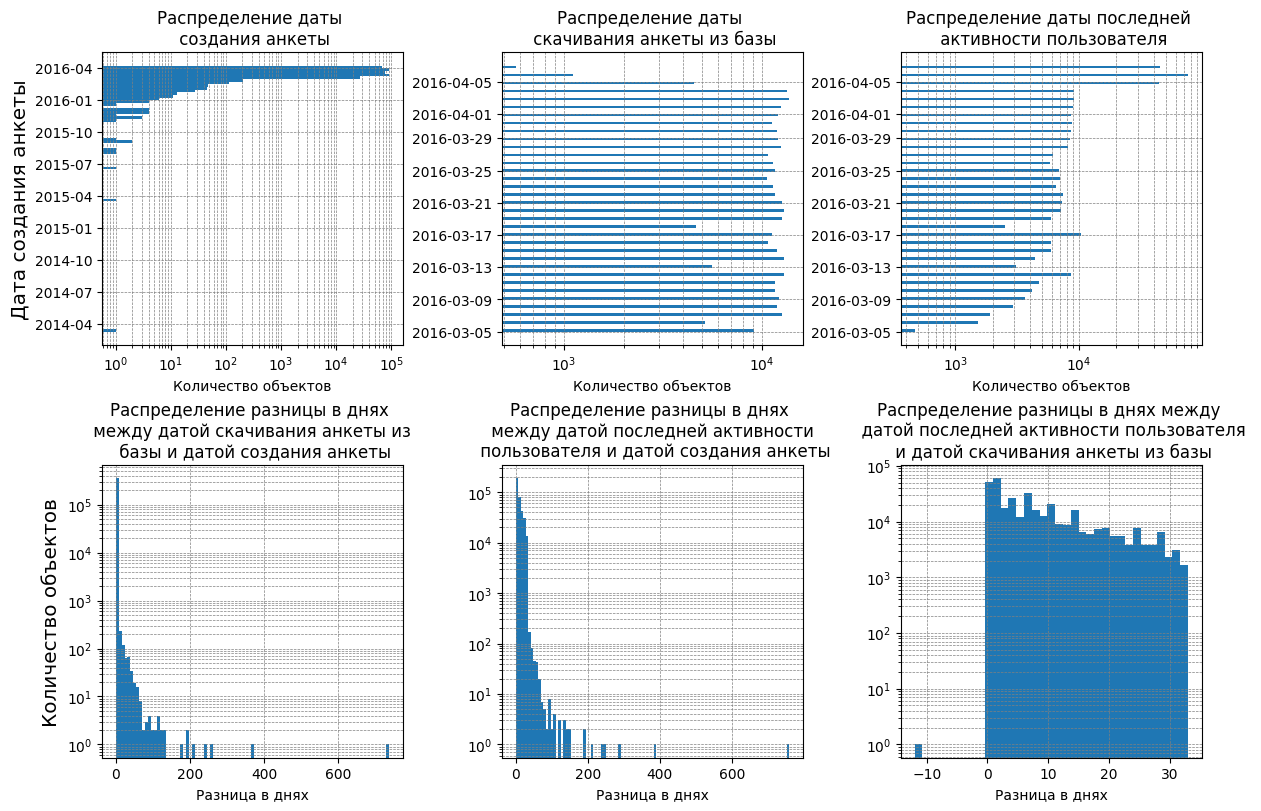

In [41]:
# Посмотрим, на сколько дней отличаются значения в рассматриваемых столбцах
fig = plt.figure(figsize=(12, 8),
                 constrained_layout=True)
gs = fig.add_gridspec(2, 3)

# Слева вверху построим распределение даты создания анкеты.
f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.set_title('Распределение даты \n создания анкеты')
f_ax1.set_ylabel('Дата создания анкеты', fontsize='x-large')
f_ax1.set_xlabel('Количество объектов', fontsize='medium')
f_ax1.grid(visible=True, which='both', axis='both', color='grey', linewidth = 0.5, linestyle = '--')
f_ax1.set_xscale('log')
f_ax1.hist(df['DateCreated'], bins=100, orientation='horizontal')

# Посередине вверху построим распределение даты скачивания анкеты из базы.
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.set_title('Распределение даты \n скачивания анкеты из базы')
# f_ax2.set_ylabel('Дата скачивания анкеты из базы', fontsize='x-large')
f_ax2.set_xlabel('Количество объектов', fontsize='medium')
f_ax2.grid(visible=True, which='both', axis='both', color='grey', linewidth = 0.5, linestyle = '--')
f_ax2.set_xscale('log')
f_ax2.hist(df['DateCrawled'], bins=100, orientation='horizontal')

# Справа вверху построим распределение даты последней активности пользователя.
f_ax3 = fig.add_subplot(gs[0, 2])
f_ax3.set_title('Распределение даты последней \n активности пользователя')
#f_ax3.set_ylabel('Дата последней активности пользователя', fontsize='x-large')
f_ax3.set_xlabel('Количество объектов', fontsize='medium')
f_ax3.grid(visible=True, which='both', axis='both', color='grey', linewidth = 0.5, linestyle = '--')
f_ax3.set_xscale('log')
f_ax3.hist(df['LastSeen'], bins=100, orientation='horizontal')

# Слева внизу построим распределение разницы в днях между датой скачивания анкеты из
# базы и датой создания анкеты.
f_ax4 = fig.add_subplot(gs[1, 0])
f_ax4.set_title('Распределение разницы в днях \n между датой скачивания анкеты из \n базы и датой создания анкеты')
f_ax4.set_xlabel('Разница в днях', fontsize='medium')
f_ax4.set_ylabel('Количество объектов', fontsize='x-large')
f_ax4.grid(visible=True, which='both', axis='both', color='grey', linewidth = 0.5, linestyle = '--')
f_ax4.set_yscale('log')
f_ax4.hist(((df['DateCrawled'] - df['DateCreated']).dt.days), bins=93)

# Посередине внизу построим распределение разницы в днях между датой последней активности
# пользователя и датой скачивания анкеты из базы.
f_ax5 = fig.add_subplot(gs[1, 1])
f_ax5.set_title('Распределение разницы в днях \n между датой последней активности \n пользователя и датой создания анкеты')
f_ax5.set_xlabel('Разница в днях', fontsize='medium')
# f_ax5.set_ylabel('Количество объектов', fontsize='x-large')
f_ax5.grid(visible=True, which='both', axis='both', color='grey', linewidth = 0.5, linestyle = '--')
f_ax5.set_yscale('log')
f_ax5.hist(((df['LastSeen'] - df['DateCreated']).dt.days), bins=109)

# Справа внизу построим распределение разницы в днях между датой последней активности
# пользователя и датой скачивания анкеты из базы.
f_ax6 = fig.add_subplot(gs[1, 2])
f_ax6.set_title('Распределение разницы в днях между \n  датой последней активности пользователя \n и датой скачивания анкеты из базы')
f_ax6.set_xlabel('Разница в днях', fontsize='medium')
# f_ax6.set_ylabel('Количество объектов', fontsize='x-large')
f_ax6.grid(visible=True, which='both', axis='both', color='grey', linewidth = 0.5, linestyle = '--')
f_ax6.set_yscale('log')
f_ax6.hist(((df['LastSeen'] - df['DateCrawled']).dt.days), bins=35)

plt.show()

Видно, что анкеты скачивались из базы в течение месяца с 05.03.2016 по 05.04.2016 г. В этот же промежуток времени попадает и последняя активность пользователей, за исключением одного объекта, по которому последняя активность наблюдалась до скачивания анкеты из базы. С точки зрения предсказания цены дата скачивания нам не интересна, тем более для подавляющего большинства объектов дата скачивания анкеты из базы и дата создания анкеты не оличаются более, чем на несколько дней. Удалим столбец с датой скачивания анкеты из базы.

In [42]:
df=df.drop(['DateCrawled'], axis=1)

In [43]:
# Изучим столбец NumberOfPictures
df['NumberOfPictures'].describe()

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

In [44]:
# Столбец NumberOfPictures не несёт никакой информации, поэтому удалим его
df = df.drop(['NumberOfPictures'], axis=1)

In [45]:
# Столбец PostalCode с точки зрения предсказания цены сам по себе не несёт
# ценной информации, а данных для трансформирования данного признака в
# географическое местоположение продавца у нас в наличии нет, поэтому удалим его
df = df.drop(['PostalCode'], axis=1)

In [46]:
# Изучим столбец с целевым признаком Price
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

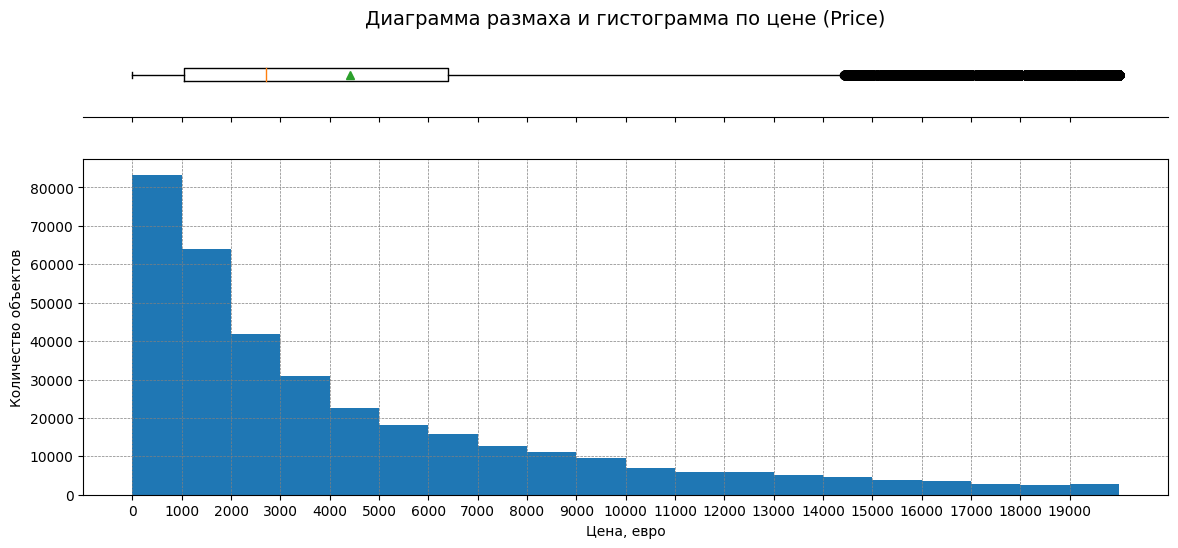

In [47]:
# Построим диаграмму размаха (boxplot) и гистограмму
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(14, 6),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.2, .8)})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')
ax[1].set_xticks(np.arange(0, 20000, 1000))
ax[0].set_title('Диаграмма размаха и гистограмма по цене (Price)', fontsize=14)
ax[1].set_xlabel('Цена, евро')
ax[1].set_ylabel('Количество объектов')

# Построим сами диаграммы
ax[0].boxplot(df[~(df['Price'].isna())]['Price'], vert=False, showmeans=True)
ax[1].hist(df['Price'], bins=20)
plt.show()

In [48]:
print('Объектов с нулевой ценой: ', df[df['Price']==0]['Price'].count(), ', ', round(df[df['Price']==0]['Price'].count()/df.shape[0], 3), sep='')

Объектов с нулевой ценой: 10772, 0.03


In [49]:
df[df['Price']==0].sample(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen
48920,0,wagon,1999,manual,109,focus,150000,1,petrol,ford,no info,2016-03-15,2016-03-16
313521,0,sedan,2007,manual,306,3er,125000,10,petrol,bmw,no,2016-04-05,2016-04-05
296909,0,sedan,2015,manual,136,3er,20000,10,petrol,bmw,no info,2016-03-09,2016-03-15
211138,0,other,2000,manual,54,corsa,150000,6,petrol,opel,no info,2016-03-24,2016-04-05
215924,0,small,1997,manual,54,corsa,150000,6,petrol,opel,no info,2016-04-04,2016-04-06
176979,0,other,2013,manual,98,other,60000,4,other,citroen,no info,2016-03-25,2016-03-28
97605,0,sedan,1999,manual,125,toledo,150000,12,petrol,seat,no,2016-03-17,2016-03-20
17478,0,sedan,2001,manual,101,focus,150000,6,lpg,ford,no,2016-03-17,2016-04-07
27590,0,other,2005,manual,140,other,150000,8,other,suzuki,no,2016-03-17,2016-03-19
150634,0,other,2014,manual,148,other,5000,9,other,sonstige_autos,no info,2016-03-23,2016-04-06


В столбце с ценой имеются подозрительные значения (низкая цена), например, 0 евро. Удалим нулевые значения, поскольку пользователю модели предсказание цены ноль евро не потребуется.

In [50]:
df = df[df['Price']!=0].copy()

### Разработка новых синтетических признаков

In [51]:
# На основе данных в столбцах LastSeen и DateCreated создадим столбец с длительностью
# интервала между созданием анкеты и последней активностью пользователя в днях.
df['blank_age'] = (df['LastSeen'] - df['DateCreated']).dt.days

In [52]:
# Посмотрим статистики данных в полученном столбце
df['blank_age'].describe()

count    343593.000000
mean          8.723327
std           8.654754
min           0.000000
25%           2.000000
50%           6.000000
75%          13.000000
max         759.000000
Name: blank_age, dtype: float64

In [53]:
# Сами по себе столбцы LastSeen, DateCreated с точки зрения предсказания цены
# информации не несут, поэтому удалим их
df = df.drop(['LastSeen', 'DateCreated'], axis=1)

In [54]:
# Посмотрим сведения о датасете после всех изменений
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343593 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343593 non-null  int64 
 1   VehicleType        343593 non-null  object
 2   RegistrationYear   343593 non-null  int64 
 3   Gearbox            343593 non-null  object
 4   Power              343593 non-null  int32 
 5   Model              343593 non-null  object
 6   Kilometer          343593 non-null  int64 
 7   RegistrationMonth  343593 non-null  int32 
 8   FuelType           343593 non-null  object
 9   Brand              343593 non-null  object
 10  Repaired           343593 non-null  object
 11  blank_age          343593 non-null  int64 
dtypes: int32(2), int64(4), object(6)
memory usage: 31.5+ MB


### Подготовка данных для моделей

In [55]:
# Обновим переменные с обучающей и тестовой выборками
train = df[df.index.isin(train_index)].copy()
test = df[df.index.isin(test_index)].copy()

In [56]:
train.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'blank_age'],
      dtype='object')

In [57]:
# Разделим признаки
X = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'blank_age']
y = ['Price']

In [58]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [59]:
# Составим список числовых признаков
numeric = train[X].select_dtypes(include=['int64']).columns.to_list()
numeric

['RegistrationYear', 'Kilometer', 'blank_age']

#### Кодирование признаков для линейной регрессии

In [60]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(train[cat_features])

# добавляем закодированные признаки в train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_ohe_scaled = train[X].copy()
transformed_features = pd.DataFrame(encoder_ohe.transform(features_train_ohe_scaled[cat_features]),
                                    columns = encoder_ohe.get_feature_names_out(),
                                    index=train.index)
features_train_ohe_scaled = pd.concat([features_train_ohe_scaled, transformed_features], axis=1)

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe_scaled = features_train_ohe_scaled.drop(cat_features, axis=1)

# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для тестовой выборки
features_test_ohe_scaled = test[X].copy()
transformed_features = pd.DataFrame(encoder_ohe.transform(features_test_ohe_scaled[cat_features]),
                                    columns = encoder_ohe.get_feature_names_out(),
                                    index=test.index)
features_test_ohe_scaled = pd.concat([features_test_ohe_scaled, transformed_features], axis=1)
features_test_ohe_scaled = features_test_ohe_scaled.drop(cat_features, axis=1)

# Проверим результаты
print('features_train_ohe_scaled', features_train_ohe_scaled.shape)
print('features_test_ohe_scaled', features_test_ohe_scaled.shape)

features_train_ohe_scaled (274926, 307)
features_test_ohe_scaled (68667, 307)


C:\Users\Дмитрий\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Масштабирование числовых признаков для линейной регрессии

In [61]:
# Выполним масштабирование числовых признаков
scaler = MinMaxScaler()
scaler.fit(train[numeric])
features_train_ohe_scaled[numeric] = scaler.transform(features_train_ohe_scaled[numeric])

# C подготовленным на обучающей выборке скалером выполним масштабирование признаков тестовой выборки
features_test_ohe_scaled[numeric] = scaler.transform(features_test_ohe_scaled[numeric])

In [62]:
# Посмотрим первые строки выборок после преобразований
display (features_train_ohe_scaled.head(3))
display (features_test_ohe_scaled.head(3))

,RegistrationYear,Power,Kilometer,RegistrationMonth,blank_age,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no info,Repaired_yes
0,0.235294,101,1.000000,6,0.018445,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.764706,190,0.827586,5,0.018445,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.558824,163,0.827586,8,0.028986,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,RegistrationYear,Power,Kilometer,RegistrationMonth,blank_age,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no info,Repaired_yes
15,0.470588,60,0.0,5,0.010540,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21,0.500000,231,1.0,7,0.014493,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.147059,118,1.0,10,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Кодирование категориальных признаков для моделей на основе решающего дерева

Признаки для моделей на основе решающего дерева закодируем двумя способами - с применением ordinal encoder и target encoder.

In [63]:
# задаём handle_unknown='use_encoded_value':
# ранее невстречающиеся значения признака (при transform) кодируются значением -1
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ordinal.fit(train[cat_features])

# добавляем закодированные признаки в features_train
features_train_ordinal = train[X].copy()
features_train_ordinal[cat_features] = pd.DataFrame(encoder_ordinal.
                                                    transform(train[cat_features]),
                                                    columns=cat_features,
                                                    index=train.index)

# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для тестовой выборки
features_test_ordinal = test[X].copy()
features_test_ordinal[cat_features] = pd.DataFrame(encoder_ordinal.
                                                   transform(test[cat_features]),
                                                   columns=cat_features,
                                                   index=test.index)
# Проверим результаты
print('features_train_ordinal', features_train_ordinal.shape)
print('features_test_ordinal', features_test_ordinal.shape)

features_train_ordinal (274926, 11)
features_test_ordinal (68667, 11)


In [64]:
# Посмотрим первые строки выборок после преобразований
display (features_train_ordinal.head(3))
display (features_test_ordinal.head(3))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,blank_age
0,3.0,1993,1.0,101,116.0,150000,6,6.0,38.0,1.0,14
1,2.0,2011,1.0,190,166.0,125000,5,2.0,1.0,2.0,14
2,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0,22


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,blank_age
15,5.0,2001,1.0,60,128.0,5000,5,6.0,10.0,1.0,8
21,4.0,2002,1.0,231,15.0,150000,7,6.0,2.0,0.0,11
24,4.0,1990,0.0,118,166.0,150000,10,6.0,20.0,2.0,0


In [65]:
target_encoder = TargetEncoder(verbose=1, cols=cat_features, drop_invariant=False, return_df=True,
                 handle_missing='value', handle_unknown='value', min_samples_leaf=20,
                 smoothing=10, hierarchy=None)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
target_encoder.fit(train[cat_features], train[y])

# добавляем закодированные признаки в features_train
features_train_target = train[X].copy()
features_train_target[cat_features] = pd.DataFrame(target_encoder.
                                                   transform(train[cat_features]),
                                                   columns=cat_features,
                                                   index=train.index)
# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для тестовой выборки
features_test_target = test[X].copy()
features_test_target[cat_features] = pd.DataFrame(target_encoder.
                                                  transform(test[cat_features]),
                                                  columns=cat_features,
                                                  index=test.index)
# Посмотрим первые строки выборок после преобразований
display (features_train_target.head(3))
display (features_test_target.head(3))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,blank_age
0,2730.752091,1993,3994.953763,101,4311.437716,150000,6,3853.778783,4527.097652,2831.430315,14
1,6198.036380,2011,3994.953763,190,4013.563021,125000,5,6688.581418,6432.522770,2024.702553,14
2,9181.602771,2004,6875.082248,163,6430.736018,125000,8,6688.581418,7353.678431,2831.430315,22


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,blank_age
15,2736.537224,2001,3994.953763,60,1452.401701,5000,5,3853.778783,3261.699328,2831.430315,8
21,4838.071213,2002,3994.953763,231,6555.585583,150000,7,3853.778783,6350.125423,5374.259208,11
24,4838.071213,1990,6875.082248,118,4013.563021,150000,10,3853.778783,6032.193088,2024.702553,0


**Выводы по итогам предобработки данных.**

Обработка пропусков и аномалий по признакам:
- `DateCrawled` (дата скачивания анкеты из базы): удалён, поскольку для целей построения модели предсказания цены не несёт ценной информации,
- `RegistrationYear` (год регистрации автомобиля): аномальные значения заменены медианой для автомобилей с таким же пробегом,
- `RegistrationMonth` (месяц регистрации автомобиля): аномальные значения заменены медианой для автомобилей с такими же пробегом и годом регистрации, а оставшиеся пропуски заменены модой по столбцу месяц,
- `Gearbox` (тип коробки передач): пропуски заполнены модой по автомобилям такой же марки,
- `Power` (мощность, л. с.): аномальные значения заменены медианой для автомобилей с такими же маркой и моделью, а оставшиеся пропуски заменены модой по марке,
- `Model` (модель автомобиля): исключён неявный дубликат, пропуски заполнены заглушкой `other`,
- `Kilometer` (пробег, км): пропусков и аномалий нет,
- `FuelType` (тип топлива): пропуски заполнены заглушкой `other`,
- `Repaired` (была машина в ремонте или нет): пропуски заполнены заглушкой `no info`,
- `VehicleType` (тип автомобильного кузова): пропуски заполнены заглушкой `other`,
- `Brand` (марка автомобиля): пропусков и аномалий нет,
- `DateCreated` (дата создания анкеты): пропусков и аномалий нет,
- `NumberOfPictures` (количество фотографий автомобиля): столбец удалён, так как все значения нулевые,
- `PostalCode`: (почтовый индекс владельца анкеты (пользователя)): столбец удалён, так как с точки зрения предсказания цены сам по себе не несёт ценной информации, а данных для трансформирования данного признака в географическое местоположение продавца у нас в наличии нет,
- `LastSeen` (дата последней активности пользователя): пропусков и аномалий нет,
- `Price` (цена (евро)): имеются подозрительно низкие значения цены, однако закономерностей, которые позволили бы признать такие значения ошибочными и исправить их, не выявлено.

Подготовка данных для моделей:
- выполнено кодирование категориальных признаков (OneHotEncoding) и масштабирование числовых признаков (MinMaxScaler) для линейной модели,
- выполнено кодирование категориальных признаков для моделей на основе решающего дерева двумя способами: ordinal encoding, target encoding.

Данные для моделей подготовлены, можно переходить к обучению моделей.

## Обучение моделей

In [66]:
# Данные о результатах моделей сведём в таблицу
compare_models = pd.DataFrame({'Модель':[], 'HP_1':[], 'HP_2':[], 'fit_time':[],'predict_time':[],'RMSE_mean':[]})

### Модель линейной регрессии

In [67]:
%%time
row = 0
# Для поиска наилучшей модели будем менять параметры модели: max_iter, alpha
compare_models = compare_models.loc[~(compare_models['Модель']=='Линейная регрессия')]
for max_iter in range(1000, 32000, 10000):
    for alpha in [100, 10, 1, 0.1, 0.01]:
        # Обучим модель линейной регресии и проверим значение RMSE
        # путём кросс-валидации
        model = Ridge(random_state=RANDOM_STATE, max_iter=max_iter, alpha=alpha)
        cv_results = cross_validate(model, features_train_ohe_scaled, train[y], cv=3,
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
        compare_models.loc[row, 'Модель'] = 'Линейная регрессия'
        compare_models.loc[row, 'RMSE_mean'] = -cv_results['test_score'].mean()
        compare_models.loc[row, 'HP_1'] = 'max_iter: '+ str(max_iter)
        compare_models.loc[row, 'HP_2'] = 'alpha: '+ str(round(alpha, 2))
        compare_models.loc[row, 'fit_time'] = cv_results['fit_time'].mean()
        compare_models.loc[row, 'predict_time'] = cv_results['score_time'].mean()
        row += 1
compare_models.loc[compare_models['Модель']=='Линейная регрессия', :]

CPU times: total: 5.03 s
Wall time: 46.9 s


,Модель,HP_1,HP_2,fit_time,predict_time,RMSE_mean
0,Линейная регрессия,max_iter: 1000,alpha: 100,1.180406,0.109382,2533.091255
1,Линейная регрессия,max_iter: 1000,alpha: 10,1.021903,0.107276,2507.578073
2,Линейная регрессия,max_iter: 1000,alpha: 1,1.027577,0.095148,2505.024372
3,Линейная регрессия,max_iter: 1000,alpha: 0.1,1.007090,0.081112,2505.050959
4,Линейная регрессия,max_iter: 1000,alpha: 0.01,1.038420,0.096422,2505.062775
5,Линейная регрессия,max_iter: 11000,alpha: 100,1.000086,0.078324,2533.091255
6,Линейная регрессия,max_iter: 11000,alpha: 10,1.050722,0.105777,2507.578073
7,Линейная регрессия,max_iter: 11000,alpha: 1,1.032404,0.140633,2505.024372
8,Линейная регрессия,max_iter: 11000,alpha: 0.1,1.014764,0.110823,2505.050959
9,Линейная регрессия,max_iter: 11000,alpha: 0.01,1.010496,0.078130,2505.062775


### Модель на основе случайного леса

In [68]:
%%time
# Перебирая параметры n_estimators, max_depth выберем модель на основе случайного леса,
# обеспечивающую максимальные показатели качества по итогам кросс-валидации
compare_models = compare_models.loc[~((compare_models['Модель']=='Случайный лес ordinal')| \
                                     (compare_models['Модель']=='Случайный лес target'))]
if len(compare_models.index) != 0:
    row = max(compare_models.index)+1
else:
    row = 0
for est in [25, 50, 75]:
    for depth in [10, 20]:
        compare_models.loc[row, 'HP_1'] = 'max_depth: '+ str(round(depth,0))
        compare_models.loc[row, 'HP_2'] = 'n_estimators: '+ str(round(est, 0))
        model = RandomForestRegressor(random_state=RANDOM_STATE,
                                       n_estimators=est,
                                       max_depth=depth)
        cv_results_ordinal = cross_validate(model, features_train_ordinal,
                                            train[y], cv=3,
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
        compare_models.loc[row, 'Модель'] = 'Случайный лес ordinal'
        compare_models.loc[row, 'RMSE_mean'] = -cv_results_ordinal['test_score'].mean()
        compare_models.loc[row, 'fit_time'] = cv_results_ordinal['fit_time'].mean()
        compare_models.loc[row, 'predict_time'] = cv_results_ordinal['score_time'].mean()
        row += 1
        compare_models.loc[row, 'HP_1'] = 'max_depth: '+ str(round(depth,0))
        compare_models.loc[row, 'HP_2'] = 'n_estimators: '+ str(round(est, 0))
        cv_results_target = cross_validate(model, features_train_target,
                                           train[y], cv=3,
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
        compare_models.loc[row, 'Модель'] = 'Случайный лес target'
        compare_models.loc[row, 'RMSE_mean'] = -cv_results_target['test_score'].mean()
        compare_models.loc[row, 'fit_time'] = cv_results_target['fit_time'].mean()
        compare_models.loc[row, 'predict_time'] = cv_results_target['score_time'].mean()
        row += 1

CPU times: total: 328 ms
Wall time: 3min 3s


In [69]:
compare_models.loc[((compare_models['Модель']=='Случайный лес ordinal')| \
                    (compare_models['Модель']=='Случайный лес target')), :]

,Модель,HP_1,HP_2,fit_time,predict_time,RMSE_mean
20,Случайный лес ordinal,max_depth: 10,n_estimators: 25,5.126878,0.225165,1973.783767
21,Случайный лес target,max_depth: 10,n_estimators: 25,4.988215,0.146201,1871.454636
22,Случайный лес ordinal,max_depth: 20,n_estimators: 25,9.379637,0.437381,1718.440235
23,Случайный лес target,max_depth: 20,n_estimators: 25,9.260122,0.428302,1675.187970
24,Случайный лес ordinal,max_depth: 10,n_estimators: 50,10.559014,0.276145,1969.224820
25,Случайный лес target,max_depth: 10,n_estimators: 50,10.013197,0.272804,1867.103174
26,Случайный лес ordinal,max_depth: 20,n_estimators: 50,18.808790,0.871146,1702.874437
27,Случайный лес target,max_depth: 20,n_estimators: 50,18.365839,0.813218,1658.993767
28,Случайный лес ordinal,max_depth: 10,n_estimators: 75,15.036650,0.419714,1967.987138
29,Случайный лес target,max_depth: 10,n_estimators: 75,15.519203,0.412041,1866.250201


### Градиентный бустинг (библиотека catboost)

In [70]:
# Модель
cb = CatBoostRegressor(eval_metric='RMSE',
                          loss_function='RMSE',
                          random_seed=RANDOM_STATE,
                          logging_level='Silent')
# Данные для подбора гиперпараметров
grid_param_cb = {'learning_rate': [0.1, 0.3],
                 'iterations':[1000, 3000]}

In [71]:
%%time
# Градиентный бустинг (библиотека catboost) с ordinal encoding
grid_cb_ordinal = GridSearchCV(estimator=cb, param_grid=grid_param_cb, scoring='neg_root_mean_squared_error',
                         cv=3, n_jobs=-1)
grid_cb_ordinal.fit(features_train_ordinal, train[y])

CPU times: total: 12min 51s
Wall time: 2min 1s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F818C7B550>,
             n_jobs=-1,
             param_grid={'iterations': [1000, 3000],
                         'learning_rate': [0.1, 0.3]},
             scoring='neg_root_mean_squared_error')

In [72]:
grid_cb_ordinal.best_params_

{'iterations': 3000, 'learning_rate': 0.1}

In [73]:
cb_ordinal = pd.DataFrame(grid_cb_ordinal.cv_results_)

In [74]:
%%time
# Градиентный бустинг (библиотека catboost) с target encoding
grid_cb_target = GridSearchCV(estimator=cb, param_grid=grid_param_cb, scoring='neg_root_mean_squared_error',
                         cv=3, n_jobs=-1)
grid_cb_target.fit(features_train_target, train[y])

CPU times: total: 12min 59s
Wall time: 2min 6s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F818C7B550>,
             n_jobs=-1,
             param_grid={'iterations': [1000, 3000],
                         'learning_rate': [0.1, 0.3]},
             scoring='neg_root_mean_squared_error')

In [75]:
grid_cb_target.best_params_

{'iterations': 3000, 'learning_rate': 0.1}

In [76]:
cb_target = pd.DataFrame(grid_cb_target.cv_results_)

### Градиентный бустинг (библиотека  LightGBM)

In [77]:
# Модель
lgbm = LGBMRegressor(random_state=RANDOM_STATE,
                            n_jobs=-1)
# Данные для подбора гиперпараметров
grid_param_lgbm = {'learning_rate': [0.1, 0.3],
              'reg_lambda':[0, 0.2]}

In [78]:
%%time
# Градиентный бустинг (библиотека LightGBM) с ordinal encoding
grid_lgbm_ordinal = GridSearchCV(estimator=lgbm, param_grid=grid_param_lgbm, scoring='neg_root_mean_squared_error',
                         cv=3, n_jobs=-1)
grid_lgbm_ordinal.fit(features_train_ordinal, train[y])

CPU times: total: 9.41 s
Wall time: 2.42 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'reg_lambda': [0, 0.2]},
             scoring='neg_root_mean_squared_error')

In [79]:
grid_lgbm_ordinal.best_params_

{'learning_rate': 0.3, 'reg_lambda': 0.2}

In [80]:
lgbm_ordinal = pd.DataFrame(grid_lgbm_ordinal.cv_results_)

In [81]:
%%time
# Градиентный бустинг (библиотека LightGBM) с target encoding
grid_lgbm_target = GridSearchCV(estimator=lgbm, param_grid=grid_param_lgbm, scoring='neg_root_mean_squared_error',
                         cv=3, n_jobs=-1)
grid_lgbm_target.fit(features_train_target, train[y])

CPU times: total: 10.2 s
Wall time: 2.25 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'reg_lambda': [0, 0.2]},
             scoring='neg_root_mean_squared_error')

In [82]:
grid_lgbm_target.best_params_

{'learning_rate': 0.3, 'reg_lambda': 0}

In [83]:
lgbm_target = pd.DataFrame(grid_lgbm_target.cv_results_)

In [84]:
# Добавим результаты в таблицу с результатами других моделей
cb_ordinal.loc[:, 'Модель'] = 'Catboost_ordinal'
cb_ordinal = cb_ordinal[['Модель', 'param_iterations', 'param_learning_rate', 'mean_fit_time', 'mean_score_time', 'mean_test_score']]
cb_ordinal['mean_test_score'] = -cb_ordinal['mean_test_score']
cb_ordinal['param_iterations'] = 'iterations=' + cb_ordinal['param_iterations'].apply(str)
cb_ordinal['param_learning_rate'] = 'learning_rate=' + cb_ordinal['param_learning_rate'].apply(str)
cb_ordinal.columns = compare_models.columns

cb_target.loc[:, 'Модель'] = 'Catboost_target'
cb_target = cb_target[['Модель', 'param_iterations', 'param_learning_rate', 'mean_fit_time', 'mean_score_time', 'mean_test_score']]
cb_target['mean_test_score'] = -cb_target['mean_test_score']
cb_target['param_iterations'] = 'iterations=' + cb_target['param_iterations'].apply(str)
cb_target['param_learning_rate'] = 'learning_rate=' + cb_target['param_learning_rate'].apply(str)
cb_target.columns = compare_models.columns

lgbm_ordinal.loc[:, 'Модель'] = 'LightGBM_ordinal'
lgbm_ordinal = lgbm_ordinal[['Модель', 'param_learning_rate', 'param_reg_lambda', 'mean_fit_time', 'mean_score_time', 'mean_test_score']]
lgbm_ordinal['mean_test_score'] = -lgbm_ordinal['mean_test_score']
lgbm_ordinal['param_reg_lambda'] = 'reg_lambda=' + lgbm_ordinal['param_reg_lambda'].apply(str)
lgbm_ordinal['param_learning_rate'] = 'learning_rate=' + lgbm_ordinal['param_learning_rate'].apply(str)
lgbm_ordinal.columns = compare_models.columns

lgbm_target.loc[:, 'Модель'] = 'LightGBM_target'
lgbm_target = lgbm_target[['Модель', 'param_learning_rate', 'param_reg_lambda', 'mean_fit_time', 'mean_score_time', 'mean_test_score']]
lgbm_target['mean_test_score'] = -lgbm_target['mean_test_score']
lgbm_target['param_reg_lambda'] = 'reg_lambda=' + lgbm_target['param_reg_lambda'].apply(str)
lgbm_target['param_learning_rate'] = 'learning_rate=' + lgbm_target['param_learning_rate'].apply(str)
lgbm_target.columns = compare_models.columns

In [85]:
compare_models = pd.concat([compare_models, cb_ordinal, cb_target, lgbm_ordinal, lgbm_target], axis=0)
compare_models.sort_values(by=['RMSE_mean', 'predict_time', 'fit_time'])

,Модель,HP_1,HP_2,fit_time,predict_time,RMSE_mean
2,Catboost_target,iterations=3000,learning_rate=0.1,79.039742,0.032709,1614.726674
3,Catboost_target,iterations=3000,learning_rate=0.3,87.378618,0.053387,1619.236819
2,Catboost_ordinal,iterations=3000,learning_rate=0.1,75.496755,0.031487,1625.283994
1,Catboost_target,iterations=1000,learning_rate=0.3,33.200207,0.041749,1626.650602
3,Catboost_ordinal,iterations=3000,learning_rate=0.3,78.494595,0.026998,1626.934093
1,Catboost_ordinal,iterations=1000,learning_rate=0.3,40.161967,0.029859,1638.572942
0,Catboost_target,iterations=1000,learning_rate=0.1,38.137861,0.034402,1647.968562
31,Случайный лес target,max_depth: 20,n_estimators: 75,27.445826,1.246468,1653.626689
27,Случайный лес target,max_depth: 20,n_estimators: 50,18.365839,0.813218,1658.993767
0,Catboost_ordinal,iterations=1000,learning_rate=0.1,40.234490,0.035412,1668.922550


Для дальнейшего сравнения с учётом значения RMSE, времени обучения и предсказания выберем модели:
- catboost с использованием target encoding и с параметрами iterations=1000 и learning_rate=0.3,
- LightGBM с использованием target encoding и с параметрами reg_lambda=0 и learning_rate=0.3,
- модель на основе случайного леса с использованием target encoding и с параметрами max_depth=20 и n_estimators=50.


Модель линейной регрессии существенно уступает указанным выше моделям по RMSE.

## Анализ моделей

In [86]:
%%time
# Обучим модель catboost
model_cb = CatBoostRegressor(eval_metric='RMSE', loss_function='RMSE',
                             random_seed=RANDOM_STATE, logging_level='Silent',
                             iterations=1000, learning_rate=0.3)
model_cb.fit(features_train_target, train[y])

CPU times: total: 4min 16s
Wall time: 12.2 s


In [88]:
%%time
# Получим предсказания модели catboost
predict_cb = model_cb.predict(features_test_target)

CPU times: total: 0 ns
Wall time: 8.01 ms


In [89]:
# Вычислим значение RMSE модели catboost
rmse_cb = mean_squared_error(test[y], predict_cb, squared=False)
rmse_cb

1622.935722954445

In [90]:
%%time
# Обучим модель LightGBM
model_lgbm = LGBMRegressor(reg_lambda=0.2,
                           learning_rate=0.3,
                           random_state=RANDOM_STATE,
                           n_jobs=-1)
model_lgbm.fit(features_train_target, train[y])

CPU times: total: 7.97 s
Wall time: 290 ms


LGBMRegressor(learning_rate=0.3, random_state=12345, reg_lambda=0.2)

In [91]:
%%time
# Получим предсказания модели LightGBM
predict_lgbm = model_lgbm.predict(features_test_target)

CPU times: total: 453 ms
Wall time: 22 ms


In [92]:
# Вычислим значение RMSE модели LightGBM
rmse_lgbm = mean_squared_error(test[y], predict_lgbm, squared=False)
rmse_lgbm

1689.0252005625696

In [95]:
%%time
# Обучим модель на основе случайного леса
model_rf = RandomForestRegressor(random_state=RANDOM_STATE,
                                   n_estimators=25,
                                   max_depth=20)
model_rf.fit(features_train_target, pd.Series.ravel(train[y]))

CPU times: total: 13.2 s
Wall time: 13.1 s


RandomForestRegressor(max_depth=20, n_estimators=25, random_state=12345)

In [96]:
%%time
# Получим предсказания модели на основе случайного леса
predict_rf = model_rf.predict(features_test_target)

CPU times: total: 312 ms
Wall time: 317 ms


In [97]:
# Вычислим значение RMSE модели на основе случайного леса
rmse_rf = mean_squared_error(test[y], predict_rf, squared=False)
rmse_rf

1666.2865585096447

In [98]:
pd.DataFrame({'Модель':['Catboost', 'LightGBM', 'Random forest'],
             'Время обучения':[12.2, 0.29, 13.1],
             'Время предсказания':[0.008, 0.022, 0.317],
             'RMSE':[1623, 1689, 1666]})

,Модель,Время обучения,Время предсказания,RMSE
0,Catboost,12.20,0.008,1623
1,LightGBM,0.29,0.022,1689
2,Random forest,13.10,0.317,1666


По времени предсказания и целевой метрике лидирует модель catboost. Её рекомендуется применять заказчику. Если для заказчика наиболее критично время обучения, то стоит рассмотреть модель LightGBM, время обучения которой на два порядка меньше, чем у других моделей. Модель на основе случайного леса уступает по времени предсказания всем моделям, но на втором месте по значению метрики.

**Вывод по работе:**
- произведена загрузка данных, ознакомление с ними,
- выполнена предобработка данных (заполнены пропуски, обработаны аномалии),
- выполнен подбор моделей линейной регрессии, catboost. LightGBM и на основе случайного леса,
- проведёно сравнение моделей по времени обучения/предсказания, метрике RMSE и даны рекомендации по выбору модели для использования.